In [1]:
if 1:
  !nvidia-smi

  !pip install -Uqq fastbook
  import fastbook
  fastbook.setup_book

  from google.colab import drive
  #drive.mount('/content/drive')

Sun May  9 17:04:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from fastai.tabular.all import *

In [3]:
creds = '{"username":"sandermann","key":"34a608a514ebc417693865ab9a19512b"}'

In [4]:
#shutil.rmtree(cred_path.parent)

In [5]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write_text(creds)
  cred_path.chmod(0o600)

In [6]:
from kaggle import *

In [7]:
#!kaggle competitions download -c tabular-playground-series-apr-2021

In [8]:
#file_extract(path/'tabular-playground-series-apr-2021.zip')

In [9]:
path = URLs.path('playground_april')
path

Path('/root/.fastai/archive/playground_april')

In [10]:
#shutil.rmtree(path)

In [11]:
if not path.exists():
  path.mkdir(parents=True)
  api.competition_download_cli('tabular-playground-series-apr-2021', path=path)
  file_extract(path/'tabular-playground-series-apr-2021.zip')

path.ls()

100%|██████████| 4.41M/4.41M [00:00<00:00, 35.4MB/s]

(#4) [Path('/root/.fastai/archive/playground_april/train.csv'),Path('/root/.fastai/archive/playground_april/tabular-playground-series-apr-2021.zip'),Path('/root/.fastai/archive/playground_april/test.csv'),Path('/root/.fastai/archive/playground_april/sample_submission.csv')]

In [124]:
df = pd.read_csv(path/'train.csv', low_memory=False)

In [125]:
dep_var = 'Survived'

In [126]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [152]:
df.isna().sum()

Survived       0
Pclass         0
Sex            0
Age         3292
SibSp          0
Parch          0
Ticket      4623
Fare         134
Embarked     250
dtype: int64

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


In [128]:
df.shape

(100000, 12)

In [129]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [130]:
df.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

In [131]:
procs = [Categorify, FillMissing, Normalize]

In [132]:
cont, cat = cont_cat_split(df, dep_var=dep_var)

In [133]:
cont, cat

(['Age', 'Fare'], ['Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Embarked'])

In [134]:
idx = np.random.permutation(range(len(df))).squeeze()

In [135]:
idx.shape

(100000,)

In [136]:
to = TabularPandas(df, procs, cat, cont, dep_var, CategoryBlock(), splits=RandomSplitter(seed=42)(range_of(df)))

In [137]:
len(to.train), len(to.valid)

(80000, 20000)

In [138]:
to.show(3)

,Pclass,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare,Survived
1509,3,female,1,0,9311,S,False,False,67.0,29.680000,0
83391,3,male,1,2,S.O.C. 23844,S,False,False,30.0,27.450001,0
62311,2,female,1,1,151455,C,False,False,45.0,28.690001,0


In [139]:
to.xs[:3]

,Pclass,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
1509,3,1,2,1,51792,3,1,1,1.591081,-0.204969
83391,3,2,2,3,68733,3,1,1,-0.464173,-0.237166
62311,2,1,2,2,4381,1,1,1,0.369038,-0.219263


In [140]:
dls = to.dataloaders(1024)

In [141]:
y = to.train.y
y.min(), y.max()

(0, 1)

In [145]:
learn = tabular_learner(dls, layers=[500,250], metrics=accuracy)

SuggestedLRs(lr_min=0.023442287743091584, lr_steep=0.07585775852203369)

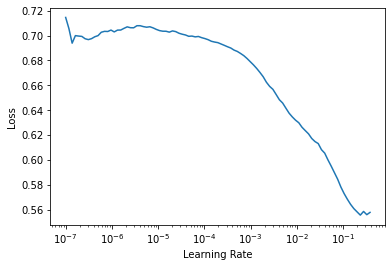

In [146]:
learn.lr_find(end_lr=1)

In [147]:
learn.fit_one_cycle(1, 1e-2) # acc: 0.76685

epoch,train_loss,valid_loss,accuracy,time
0,0.504926,0.493960,0.766850,00:02


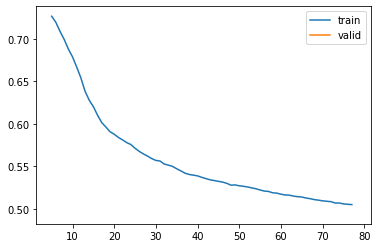

In [148]:
learn.recorder.plot_loss()

In [149]:
learn.summary()

TabularModel (Input shape: 1024 x torch.Size([1024, 2]))
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 3            
Embedding                                 12         True      
Embedding                                 9          True      
____________________________________________________________________________
                     1024 x 5            
Embedding                                 40         True      
Embedding                                 45         True      
____________________________________________________________________________
                     1024 x 600          
Embedding                                 45199200   True      
____________________________________________________________________________
                     1024 x 3            
Embedding                                 12         True      
Embedding                                 9          True      
Embedding                       

In [150]:
learn.show_results()

,Pclass,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare,Survived,Survived_pred
0,2.0,2.0,1.0,1.0,17839.0,3.0,1.0,1.0,-1.019648,-0.549602,0.0,0.0
1,3.0,1.0,1.0,1.0,69712.0,3.0,1.0,1.0,1.091154,-0.467595,1.0,1.0
2,3.0,2.0,1.0,1.0,17929.0,3.0,1.0,1.0,0.424585,-0.485354,0.0,0.0
3,3.0,2.0,1.0,1.0,19761.0,3.0,1.0,1.0,-0.686363,-0.512064,0.0,0.0
4,2.0,1.0,1.0,1.0,1371.0,3.0,1.0,1.0,-1.630669,-0.485642,1.0,1.0
5,1.0,2.0,2.0,1.0,67255.0,3.0,1.0,1.0,1.591081,0.367205,0.0,0.0
6,3.0,2.0,1.0,1.0,73351.0,3.0,1.0,1.0,-0.908553,-0.540507,0.0,0.0
7,1.0,1.0,1.0,1.0,66833.0,3.0,1.0,1.0,-0.630816,0.553743,1.0,1.0
8,3.0,2.0,1.0,1.0,42846.0,3.0,1.0,1.0,1.368891,-0.507155,0.0,0.0


# Get prediction

In [37]:
learn.get_preds()

(tensor([[0.7452, 0.2548],
         [0.9371, 0.0629],
         [0.5962, 0.4038],
         ...,
         [0.9266, 0.0734],
         [0.9270, 0.0730],
         [0.9402, 0.0598]]), tensor([[0],
         [0],
         [1],
         ...,
         [0],
         [0],
         [0]], dtype=torch.int8))

In [38]:
dft = pd.read_csv(path/'test.csv', low_memory=False)

In [39]:
dft.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

In [40]:
dl_test = learn.dls.test_dl(dft)

In [41]:
probs, _ = learn.get_preds(dl=dl_test)

In [42]:
preds = torch.argmax(probs, dim=1)

In [43]:
preds.shape

torch.Size([100000])

In [44]:
preds[:5]

tensor([0, 0, 1, 0, 1])

In [45]:
df_test = pd.read_csv(path/'test.csv', low_memory=False)

In [46]:
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': preds})

In [47]:
output.head()

,PassengerId,Survived
0,100000,0
1,100001,0
2,100002,1
3,100003,0
4,100004,1


In [48]:
output.to_csv('fastai_R00.csv', index=False)

In [49]:
api.competition_submit('/content/fastai_R00.csv', message='first try', competition='tabular-playground-series-apr-2021')

100%|██████████| 879k/879k [00:02<00:00, 341kB/s] 


Successfully submitted to Tabular Playground Series - Apr 2021